In [1]:
import os

import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import numpy as np
import pandas as pd

from src import (
    add_stats_table_row,
    bootstrap_effect_size_pd,
    bounded_mean_1d,
    dataplot,
    lighten,
    load_image,
    nb_setup,
    raw_data_path,
    rotated_embryo,
)

nb_setup()
os.makedirs("Figs", exist_ok=True)

%matplotlib inline

### Quantification

In [2]:
# Import data
df = pd.read_csv("../../../data/par2_nebd_embryos.csv")
df_quantification = pd.read_csv("../../../data/par2_nebd_quantification.csv")

# Filter relevant data
lines = ["lp637", "nwg374"]
df = df[
    ((df.Line == "lp637") & (df.RNAi == "wt"))
    | ((df.Line == "nwg374") & (df.RNAi.str.contains("pkc")))
]
df_quantification = df_quantification[df_quantification.EmbryoID.isin(df.EmbryoID)]


# Summary quantification
def calculate_summary(group):
    cyt = group["Cytoplasmic signal"].mean()
    mem_tot = group["Membrane signal"].mean()
    mem_ant = bounded_mean_1d(group["Membrane signal"], [0.4, 0.6])
    mem_post = bounded_mean_1d(group["Membrane signal"], [0.9, 0.1])
    ratio_post = mem_post / cyt
    return pd.Series(
        {
            "Cyt": cyt,
            "Mem_tot": mem_tot,
            "Mem_ant": mem_ant,
            "Mem_post": mem_post,
            "Ratio post": ratio_post,
        }
    )


df_summary = df_quantification.groupby("EmbryoID").apply(calculate_summary)
df = pd.merge(df, df_summary, on="EmbryoID")

# Add columns
df["UniPol"] = df.Line.apply(lambda x: "Pol" if x == "lp637" else "Uni")

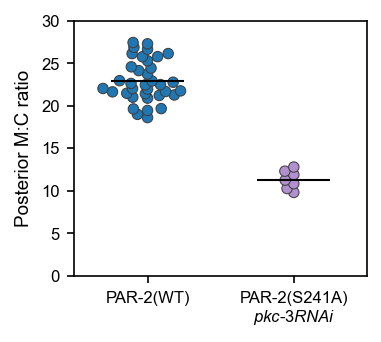

In [3]:
# Set up figure
fig, ax = plt.subplots()
fig.set_size_inches(2, 2.5)
offset = lambda p: transforms.ScaledTranslation(p / 72.0, 0, plt.gcf().dpi_scale_trans)
trans = plt.gca().transData

# Plot data
dataplot(
    data=df,
    x="UniPol",
    y="Ratio post",
    ax=ax,
    order=["Pol", "Uni"],
    transform=trans + offset(0),
    linewidth=0.5,
    offset=0,
    width=0.5,
    hue="Line",
    palette={"lp637": "tab:blue", "nwg374": lighten("tab:purple", 1.2)},
)

# Finalise plot
ax.set_xticklabels(["PAR-2(WT)", "PAR-2(S241A)\n" + r"$pkc$" + "-" + r"$3 RNAi$"])
ax.get_legend().remove()
ax.tick_params(axis="both", labelsize=8)
ax.set_xlabel("")
ax.set_ylim(0, 30)
ax.set_ylabel("Posterior M:C ratio", fontsize=9)
fig.set_size_inches(3, 2.5)
fig.subplots_adjust(left=0.25, bottom=0.2)
fig.savefig("Figs/s241a.png", dpi=600, transparent=True)
fig.savefig("Figs/s241a.pdf", transparent=True)

In [4]:
# Effect size
es, pr, ss = bootstrap_effect_size_pd(
    data=df, x="UniPol", y="Ratio post", a="Pol", b="Uni"
)
add_stats_table_row(
    figure="EV1",
    panel="A",
    sample_a="PAR-2(WT)",
    sample_b="PAR-2(S241A); pkc-3 RNAi",
    measure="Posterior M:C ratio (mean)",
    effect_size=es,
    probability_distribution=pr,
    sample_size=ss,
    key="csM3BYhk4n",
)

24670.589714538903
15158.251251261408


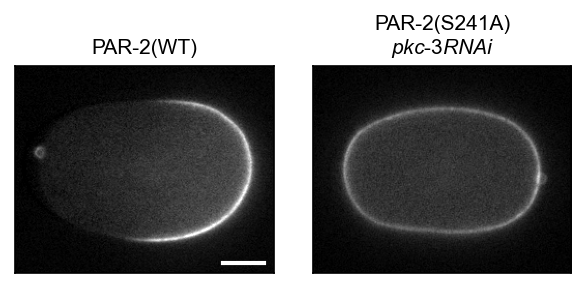

In [5]:
def panel(path, ax, scale_bar=False):
    img = load_image(path + "/af_corrected.tif")
    roi = np.loadtxt(path + "/ROI_fit.txt")
    rotated = rotated_embryo(img, roi, 250, 200, 3)
    print(np.percentile(rotated, 99.9))
    ax.imshow(rotated, cmap="gray", vmin=0, vmax=24670.589714538903)
    ax.set_xticks([])
    ax.set_yticks([])

    if scale_bar:
        px = 0.255  # pixel size
        bar_length = 10  # microns
        bar_pixels = bar_length / px
        y = rotated.shape[0] - 10
        ax.plot(
            [rotated.shape[1] - 10 - bar_pixels, rotated.shape[1] - 10],
            [y, y],
            color="w",
            linewidth=2,
        )


if raw_data_path:
    path_wt = raw_data_path + df[df.Line == "lp637"].Path.iloc[5]
    path_s241a = raw_data_path + df[df.Line == "nwg374"].Path.iloc[0]

    # Create figure
    fig, ax = plt.subplots(1, 2)
    panel(path_wt, ax[0], scale_bar=True)
    panel(path_s241a, ax[1])

    # Format figure
    ax[0].set_title("PAR-2(WT)", fontsize=10)
    ax[1].set_title("PAR-2(S241A)\n" + r"$pkc$" + "-" + r"$3 RNAi$", fontsize=10)
    fig.set_size_inches(5, 2)
    fig.subplots_adjust(top=0.8, wspace=0.05)

    # Save figure
    fig.savefig("Figs/s241a_imgs.png", dpi=600, transparent=True)
    fig.savefig("Figs/s241a_imgs.pdf", transparent=True)